In [1]:
%matplotlib inline
import json
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
with sqlite3.connect('obs_rainfall.sqlite') as conn:
    df = pd.read_sql_query('SELECT * FROM rainobs', conn)

In [3]:
col = [
    'stationName', 
    'obsTime', 
    'rain1hr', 
    'rain10min', 
    'rain3hr', 
    'rain6hr', 
    'rain12hr', 
    'rain24hr', 
    'rainToday', 
    'fromLast1dayToNow', 
    'fromLast2dayToNow'
]
df = df[col]
df.head()

,stationName,obsTime,rain1hr,rain10min,rain3hr,rain6hr,rain12hr,rain24hr,rainToday,fromLast1dayToNow,fromLast2dayToNow
0,九份二山,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
1,基隆,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
2,淡水,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
3,板橋,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
4,陽明山,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00


In [4]:
df['obsTime'] = pd.to_datetime(df['obsTime']).dt.tz_localize(None)
df.head()

,stationName,obsTime,rain1hr,rain10min,rain3hr,rain6hr,rain12hr,rain24hr,rainToday,fromLast1dayToNow,fromLast2dayToNow
0,九份二山,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
1,基隆,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
2,淡水,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
3,板橋,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
4,陽明山,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00


In [5]:
df6 = df[['stationName', 'obsTime', 'rain6hr']].copy()
df6['rain6hr'] = df6['rain6hr'].astype(float)
df6.head()

,stationName,obsTime,rain6hr
0,九份二山,2019-08-29 18:50:00,-998.0
1,基隆,2019-08-29 18:50:00,-998.0
2,淡水,2019-08-29 18:50:00,-998.0
3,板橋,2019-08-29 18:50:00,-998.0
4,陽明山,2019-08-29 18:50:00,-998.0


In [6]:
df6.loc[df6.rain6hr <= 0, 'rain6hr'] = 0
df6.head()

,stationName,obsTime,rain6hr
0,九份二山,2019-08-29 18:50:00,0.0
1,基隆,2019-08-29 18:50:00,0.0
2,淡水,2019-08-29 18:50:00,0.0
3,板橋,2019-08-29 18:50:00,0.0
4,陽明山,2019-08-29 18:50:00,0.0


In [7]:
minute_cond = df6.obsTime.dt.minute == 0
hour_cond = (df6.obsTime.dt.hour == 0) | (df6.obsTime.dt.hour == 6) | (df6.obsTime.dt.hour == 12) | (df6.obsTime.dt.hour == 18)
df6 = df6[minute_cond & hour_cond]
df6.head()

,stationName,obsTime,rain6hr
5620,九份二山,2019-08-30,0.0
5621,基隆,2019-08-30,0.0
5622,淡水,2019-08-30,0.0
5623,板橋,2019-08-30,0.0
5624,陽明山,2019-08-30,0.0


In [8]:
station2county = json.load(open('station_info.json'))
df6['county'] = df6['stationName'].map(station2county)
df6 = df6[~df6['county'].isna()]
df6.head(10)

,stationName,obsTime,rain6hr,county
5620,九份二山,2019-08-30,0.0,南投縣
5621,基隆,2019-08-30,0.0,基隆市
5622,淡水,2019-08-30,0.0,新北市
5623,板橋,2019-08-30,0.0,新北市
5624,陽明山,2019-08-30,0.0,臺北市
5625,鞍部,2019-08-30,0.0,臺北市
5626,新竹,2019-08-30,0.0,新竹縣
5627,臺中,2019-08-30,0.0,臺中市
5628,梧棲,2019-08-30,0.0,臺中市
5629,澎湖,2019-08-30,0.0,澎湖縣


In [9]:
with sqlite3.connect('county_36hr_forecast.sqlite') as conn:
    df_f = pd.read_sql_query('SELECT * FROM county', conn)

rain_f = df_f.loc[df_f['element'] == 'PoP', ['location', 'issueTime', 'startTime', 'endTime', 'value']]

# dealing with time zone
for time_type in ['issueTime', 'startTime', 'endTime']:
    rain_f[time_type] = pd.to_datetime(rain_f[time_type]).dt.tz_localize(None)
    
rain_f['lead_time'] = rain_f['startTime'] - rain_f['issueTime']
rain_f.head()

,location,issueTime,startTime,endTime,value,lead_time
12,臺北市,2019-08-28 11:00:00,2019-08-28 12:00:00,2019-08-28 18:00:00,0,01:00:00
13,臺北市,2019-08-28 11:00:00,2019-08-28 18:00:00,2019-08-29 06:00:00,0,07:00:00
14,臺北市,2019-08-28 11:00:00,2019-08-29 06:00:00,2019-08-29 18:00:00,30,19:00:00
27,新北市,2019-08-28 11:00:00,2019-08-28 12:00:00,2019-08-28 18:00:00,0,01:00:00
28,新北市,2019-08-28 11:00:00,2019-08-28 18:00:00,2019-08-29 06:00:00,0,07:00:00


In [10]:
leadtime_idx = rain_f['lead_time'] == '01:00:00'
rain_f_l1 = rain_f.loc[leadtime_idx, ['location', 'startTime', 'value']]
rain_f_l1['value'] = rain_f_l1['value'].astype(int)
rain_f_l1.head()

,location,startTime,value
12,臺北市,2019-08-28 12:00:00,0
27,新北市,2019-08-28 12:00:00,0
42,桃園市,2019-08-28 12:00:00,0
57,臺中市,2019-08-28 12:00:00,0
72,臺南市,2019-08-28 12:00:00,0


In [11]:
df6_fpop = df6.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
df6_fpop.head(10)

,stationName,obsTime,rain6hr,county,location,startTime,value
0,九份二山,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
1,日月潭,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
2,玉山,2019-08-30,4.0,南投縣,南投縣,2019-08-30,30
3,阿眉,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
4,新高口,2019-08-30,2.0,南投縣,南投縣,2019-08-30,30
5,清流,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
6,長豐,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
7,雙冬,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
8,中寮,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
9,瑞岩,2019-08-30,5.5,南投縣,南投縣,2019-08-30,30


In [12]:
df6_g = df6.groupby(['county', 'obsTime']).sum()
df6_fpop = df6_g.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
df6_fpop.head(10)

,rain6hr,location,startTime,value
0,394.0,南投縣,2019-08-30 00:00:00,30
1,10.0,南投縣,2019-08-30 06:00:00,70
2,31.5,南投縣,2019-08-30 12:00:00,70
3,2353.5,南投縣,2019-08-30 18:00:00,20
4,175.5,南投縣,2019-08-31 00:00:00,0
5,10.0,南投縣,2019-08-31 18:00:00,10
6,7.0,南投縣,2019-09-01 06:00:00,50
7,2.5,南投縣,2019-09-01 12:00:00,50
8,1033.0,南投縣,2019-09-01 18:00:00,0
9,4.5,南投縣,2019-09-02 00:00:00,10


In [13]:
df6_fpop.loc[df6_fpop['rain6hr'] > 0, 'rain6hr'] = 1
fpop_tpop = df6_fpop.groupby('value').mean().sort_index()
fpop_tpop

,rain6hr
value,
0,0.178944
10,0.464319
20,0.574160
30,0.701550
40,0.719595
50,0.787781
60,0.769565
70,0.841509
80,0.843318


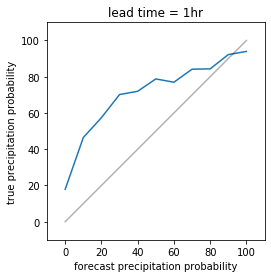

In [14]:
plt.plot(fpop_tpop*100)   # convert to %
plt.plot([0, 50, 100], [0, 50, 100], 'k', alpha=0.3)
plt.title('lead time = 1hr')
plt.xlabel('forecast precipitation probability')
plt.ylabel('true precipitation probability')
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.gca().set_aspect('equal', adjustable='box')

### 簡單校正，把某個自動站在6小時內累積雨量<=0.5mm的設為0

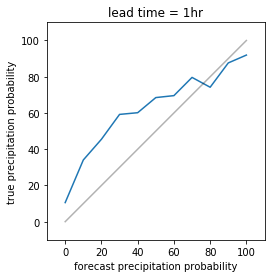

In [54]:
tdf6 = df6.copy()
tdf6.loc[tdf6.rain6hr <= 0.5, 'rain6hr'] = 0

tdf6_fpop = tdf6.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
tdf6_fpop.head(10)

tdf6_g = tdf6.groupby(['county', 'obsTime']).sum()
tdf6_fpop = tdf6_g.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
tdf6_fpop.head(10)

tdf6_fpop.loc[tdf6_fpop['rain6hr'] > 0, 'rain6hr'] = 1
tfpop_tpop = tdf6_fpop.groupby('value').mean().sort_index()


plt.plot(tfpop_tpop*100)   # convert to %
plt.plot([0, 50, 100], [0, 50, 100], 'k', alpha=0.3)
plt.title('lead time = 1hr')
plt.xlabel('forecast precipitation probability')
plt.ylabel('true precipitation probability')
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.gca().set_aspect('equal', adjustable='box')

### 改用局屬站當代表

In [77]:
main_stations = []
with open('main_station_info.txt', encoding='utf-8') as f:
    while True:
        line = f.readline()
        if line == '':
            break

        words = line.split()
        if words[1].isnumeric():
            name = words[0]
        elif words[2].isnumeric():
            name = words[0] + words[1]
            
        name = name.split('(')[0]   # 新港(成功) -> 新港
        main_stations.append(name)
        
main_stations

['台北',
 '板橋',
 '台中',
 '澎湖',
 '恒春',
 '台南',
 '台東',
 '彭佳嶼',
 '花蓮',
 '高雄',
 '阿里山',
 '宜蘭',
 '竹子湖',
 '鞍部',
 '鞍部',
 '新竹',
 '新港',
 '永康',
 '大武',
 '日月潭',
 '蘭嶼',
 '淡水',
 '玉山',
 '東吉島',
 '嘉義',
 '梧棲',
 '蘇澳']

In [84]:
tdf6_main = tdf6[tdf6['stationName'].isin(main_stations)].copy()
tdf6_main.head(10)

,stationName,obsTime,rain6hr,county
5622,淡水,2019-08-30,0.0,新北市
5623,板橋,2019-08-30,0.0,新北市
5625,鞍部,2019-08-30,0.0,臺北市
5626,新竹,2019-08-30,0.0,新竹縣
5628,梧棲,2019-08-30,0.0,臺中市
5629,澎湖,2019-08-30,0.0,澎湖縣
5630,日月潭,2019-08-30,0.0,南投縣
5631,阿里山,2019-08-30,0.0,嘉義縣
5632,玉山,2019-08-30,4.0,南投縣
5633,嘉義,2019-08-30,0.0,嘉義市


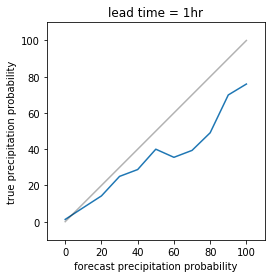

In [85]:
tdf6_main.loc[tdf6_main.rain6hr <= 0.5, 'rain6hr'] = 0

tdf6_fpop = tdf6_main.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
tdf6_fpop.head(10)

tdf6_g = tdf6_main.groupby(['county', 'obsTime']).sum()
tdf6_fpop = tdf6_g.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
tdf6_fpop.head(10)

tdf6_fpop.loc[tdf6_fpop['rain6hr'] > 0, 'rain6hr'] = 1
tfpop_tpop = tdf6_fpop.groupby('value').mean().sort_index()


plt.plot(tfpop_tpop*100)   # convert to %
plt.plot([0, 50, 100], [0, 50, 100], 'k', alpha=0.3)
plt.title('lead time = 1hr')
plt.xlabel('forecast precipitation probability')
plt.ylabel('true precipitation probability')
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.gca().set_aspect('equal', adjustable='box')

### 用局屬測站但是拿掉一些

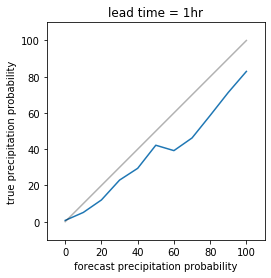

In [87]:
main_stations = [
    '台北',
    '板橋',
    '台中',
    '澎湖',
    '恒春',
    '台南',
    '台東',
    '花蓮',
    '高雄',
    '宜蘭',
    '鞍部',
    '新竹',
    '新港',
    '永康',
    '大武',
    '日月潭',
    '淡水',
    '嘉義',
    '梧棲',
    '蘇澳'
]

tdf6_main = tdf6[tdf6['stationName'].isin(main_stations)].copy()
tdf6_main.loc[tdf6_main.rain6hr <= 0.5, 'rain6hr'] = 0

tdf6_fpop = tdf6_main.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
tdf6_fpop.head(10)

tdf6_g = tdf6_main.groupby(['county', 'obsTime']).sum()
tdf6_fpop = tdf6_g.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
tdf6_fpop.head(10)

tdf6_fpop.loc[tdf6_fpop['rain6hr'] > 0, 'rain6hr'] = 1
tfpop_tpop = tdf6_fpop.groupby('value').mean().sort_index()


plt.plot(tfpop_tpop*100)   # convert to %
plt.plot([0, 50, 100], [0, 50, 100], 'k', alpha=0.3)
plt.title('lead time = 1hr')
plt.xlabel('forecast precipitation probability')
plt.ylabel('true precipitation probability')
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.gca().set_aspect('equal', adjustable='box')

### 拿每日雨量歷史資料來看

In [133]:
# get taipei station daily rainfall observation
import requests
from bs4 import BeautifulSoup

year = 2019
url = (
    f'https://www.cwb.gov.tw/V8/C/D/MOD/DayRain/466920_{year}'
    '.html?Tue%20Feb%2025%202020%2021:40:57%20GMT+0800%20(%E5%8F%B0%E5%8C%97%E6%A8%99%E6%BA%96%E6%99%82%E9%96%93)'
)
resp = requests.get(url)
soup = BeautifulSoup(str(resp.content, encoding='utf-8'))
soup.find_all('tr')[0]

trs = soup.find_all('tr')
for tr in trs:
    date = tr.find('th').text
    #print('Date:', date)
    
    tds = tr.find_all('td')
    for td in tds:
        amount = td.text
        if amount == '':
            amount = 'N'
        #print(amount, end='|')
    #print()
    
    
year_daily_rain = {i: [] for i in range(1, 13)}
trs = soup.find_all('tr')
for tr in trs:
    date = tr.find('th').text
    if not date.isnumeric():
        # 總和欄
        break
        
    tds = tr.find_all('td')
    for i, td in enumerate(tds):          
        amount = td.text
        if amount == '-':
            amount = '0'
        elif amount == 'T':
            amount = '<0.1'
        elif amount == '':
            continue
        year_daily_rain[i+1].append(amount)
        
year_daily_rain

{1: ['2.0',
  '5.7',
  '6.4',
  '0',
  '3.5',
  '4.5',
  '0',
  '<0.1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '14.0',
  '4.5',
  '0',
  '0',
  '1.0',
  '3.2',
  '0.2',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 2: ['<0.1',
  '0',
  '0',
  '<0.1',
  '0.1',
  '0',
  '0',
  '0',
  '0.3',
  '0',
  '0',
  '0',
  '<0.1',
  '0',
  '0',
  '0',
  '0',
  '1.3',
  '1.1',
  '0',
  '0.3',
  '4.0',
  '3.0',
  '53.4',
  '0.6',
  '0',
  '<0.1',
  '0'],
 3: ['0',
  '0',
  '8.5',
  '0',
  '0.9',
  '10.5',
  '26.4',
  '17.8',
  '43.5',
  '19.1',
  '<0.1',
  '0',
  '0',
  '0',
  '7.0',
  '<0.1',
  '1.3',
  '0.1',
  '0',
  '0',
  '0',
  '<0.1',
  '4.1',
  '7.0',
  '19.9',
  '0',
  '0',
  '0',
  '14.5',
  '3.5',
  '0.1'],
 4: ['5.9',
  '0.1',
  '0.9',
  '<0.1',
  '<0.1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '18.0',
  '0.1',
  '2.5',
  '3.5',
  '3.1',
  '25.1',
  '0',
  '0',
  '8.1',
  '6.4',
  '33.0',
  '8.4',
  '0',
  '0',
  '0',
  '0',
  '<0.1',
  '<0.1',
  '0',
  '0'],


In [98]:
taipei = df6[df6['stationName'] == '臺北'].copy()
taipei

,stationName,obsTime,rain6hr,county
5652,臺北,2019-08-30 00:00:00,0.0,臺北市
11113,臺北,2019-08-30 06:00:00,0.0,臺北市
16738,臺北,2019-08-30 12:00:00,2.0,臺北市
22256,臺北,2019-08-30 18:00:00,20.5,臺北市
27962,臺北,2019-08-31 00:00:00,0.5,臺北市
44779,臺北,2019-08-31 18:00:00,0.0,臺北市
56133,臺北,2019-09-01 06:00:00,0.0,臺北市
61839,臺北,2019-09-01 12:00:00,0.0,臺北市
67533,臺北,2019-09-01 18:00:00,0.0,臺北市
73185,臺北,2019-09-02 00:00:00,0.0,臺北市
